### 学习算法的实现

关于神经网络学习的基础知识，前面已经全部介绍完了。“损失函数”、“mini-batch”、“梯度”、“梯度下降法”等关键词已经陆续登场。<br>
我们来确认一下神经网络的学习步骤，神经网络的学习步骤如下所示。<br>

**前提**<br>
神经网络存在合适的权重和偏置，调整权重和偏置以便拟合训练数据的过程称为“学习”。神经网络的学习分为下面4个步骤。

**步骤1(mini-batch)**<br>
从训练数据中随机选出一部分数据，这部分数据称为 mini-batch。我们的目标是减小 mini-batch的 损失函数的值。<br>

**步骤2(计算梯度)**<br>
为了减小 mini-batch 的损失函数的值，需要求出各个权重参数的梯度。梯度表示损失函数的值减小最多的方向。<br>

**步骤3(更新参数)**<br>
将权重参数沿梯度方向进行微小更新。

**步骤4(重复)**<br>
重复步骤1、步骤、步骤3。


神经网络的学习按照上面4个步骤进行。这个方法通过梯度下降法更新参数，不过因为这里使用的数据是随机选择的 mini batch 数据，所以又称**随机梯度下降法**(stochastic gradient descent)。“随机”指的是“随机选择的”意思，因此，随机梯度下降法是“对随机选择的数据进行的梯度下降法”。深度学习的很多框架中，随机梯度下降法一般由一个名为 **SGD** 的函数来实现。SGD 来源于随机梯度下降法的英文名称的首字母。

下面，我们来实现手写数字识别的神经网络。这里以2层神经网络(隐藏层为1层的网络)为对象，使用 MNIST 数据集进行学习。

#### 2层神经网络的类
首先，我们将这个2层神经网络实现为一个名为 TwoLayerNet 的类，实现过程如下所示。

In [2]:
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:输入数据, t:监督数据
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

我们把这个类中用到的变量和方法整理一下。

$$TwoLayerNet 类中使用的变量$$


| 变量 |说明  |
|:---|:----|
| params | 保存到神经网络的参数的字典型变量(示例变量)。<br>params['W1']是第1层的权重，params['b1']是第2层的偏置。<br>params['W2']是第2层的权重，params['b2']是第2层的偏置。
| grads | 保存梯度的字典型变量(numerical_gradient()方法的返回值)。<br>grads['W1']是第1层权重的梯度，grads['b1']是第1层偏置的梯度。<br>grads['W2']是第2层权重的梯度，grads['b2']是第2层偏置的梯度。



$$TwoLayerNet 类的方法$$


| 方法 |说明  |
|:---|:----|
| \__init\__(self, input_size, hidden_size, output_size) | 进行初始化。<br> 参数从头开始依次表示输入层的神经元数、隐藏层的神经元数、输出层的神经元数。
| predict(self, x) | 进行识别(推理)。<br> 参数x是图像数据。
| loss(self, x, t) | 计算损失函数的值。<br>参数x是图像数据，t是正确解标签（后面3个方法的参数也一样）。
| accuracyy(self, x, t) | 计算识别精度
| numerical_gradient(self, x, t) | 计算权重参数的梯度
| gradient(self, x, t) | 计算权重参数的梯度。<br>numerical_gradient()的高速版，将在下一章实现。



TwoLayerNet 类有 params 和 grads 两个字典型实例变量。params 变量中保存了权重参数，比如 params['W1'] 以 NumPy 数组的形式保存了第1层的权重参数。此外，第1层的偏置可以通过 params['b1'] 进行访问。这里来看一个例子。

In [3]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
net.params['W1'].shape # (784,100)
net.params['b1'].shape # (100,)
net.params['W2'].shape # (100,10)
net.params['b2'].shape # (10,)

(10,)

如上所示，params变量中保存了该神经网络所需的全部参数。并且，params 变量中保存的权重参数会用在推理处理(前向处理)中。<br>
推理处理的实现如下所示。

In [7]:
x = np.random.rand(100, 784) # 伪输入数据（100笔）
y = net.predict(x)

此外，与 params 变量对应，grads 变量中保存了各个参数的梯度。如下所示，使用 numerical_gradient() 方法计算梯度后，梯度的信息将保存在 grads 变量中。

In [8]:
x = np.random.rand(100, 784) # 伪输入数据（100笔）
t = np.random.rand(100, 10)  # 伪正确解标签(100笔)

grads = net.numerical_gradient(x, t) # 计算梯度

grads['W1'].shape # (784,100)
grads['b1'].shape # (100,)
grads['W2'].shape # (100,10)
grads['b2'].shape # (10,)

(10,)

接着，我们看一下 TwoLayerNet 的方法的实现。首先是 \__init\__(self, input_size, hidden_size, output_size)方法，它是类的初始化方法（生成 TwoLayerNet 示例时被调用的方法）。从第1个参数开始、依次表示输入层的神经元数、隐藏层的神经元数、输出层的神经元数。另外，因为进行手写数字识别时，输入图像的大小是784(28x28)，输出为10个类别，所以指定参数 input_size=784、output_size=10，将隐藏层的个数 hidden_size 设置为一个合适的值即可。

此外，这个初始化方法会对权重参数进行初始化。如何设置权重参数的初始值这个问题是关系到神经网络能否成功学习的重要问题。后面会详细讨论权重参数的初始化，这里只需要知道，**权重使用符合高斯分布的随机数进行初始化，偏置使用0进行初始化**。<br>
predict(self, x) 和 accuracy(self, x,t)的实现和上一章的神经网络的推理处理基本一样。<br>
loss(self, x, t) 是计算函数损失值的方法。这个方法会基于 predict() 的结果和正确解标签，计算交叉熵误差。<br>
numerical_gradient(self, x, t) 方法会计算各个参数的梯度。根据数值微分，计算各个参数相对于损失函数的梯度。

#### mini-batch 的实现

神经网络的学习的实现使用的是前面介绍过的 mini-batch xuexi 。所谓 mini-batch 学习，就是从训练数据中随机选择一部分数据(成为 mini-batch)，再以这些 mini-batch 为对象，使用梯度法更新参数的过程。下面，我们以 TwoLayerNet 类为对象，使用 MNIST 数据集进行学习。

In [5]:
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

# 超参数
iters_num = 10000 # 循环次数
train_size = x_train.shape[0] # 训练数据的大小
batch_size = 100 # 批数量
learning_rate = 0.1 # 学习率

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    print(i)
    # 获取 mini-batch
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 计算梯度
    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch) # 高速版！
    
    # 更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    # 记录学习过程
    loss = network.loss(x_batch, t_batch)
    print(loss)
    train_loss_list.append(loss)

0
2.301028394024926
1
2.2903224128948465
2
2.2809646806511665
3
2.2884177868963906
4
2.299284214734375
5
2.287838394450531
6
2.296233959560264
7
2.297510114141158
8
2.290980195072725
9
2.301388310868444
10
2.294136017083701
11
2.291691967858927
12
2.2913137903853174
13
2.2978196497987935
14
2.293203532807744
15
2.2866375955238167
16
2.2843412293283625
17
2.269499349919448
18
2.296239287589886
19
2.287970389757371
20
2.2900892831506345
21
2.2821764935439783
22
2.2945760781962776
23
2.286840339262744
24
2.2866166411249393
25
2.280128188630702
26
2.2847117576998177
27
2.293226526250327
28
2.2782659768993976
29
2.3042279650131103
30
2.293636693483892
31
2.288824428761272
32
2.2745768609842587
33
2.2939163944738308
34
2.282050720899493
35
2.2899233202817753
36
2.2644081363886652
37
2.273063568845338
38
2.289885379145292
39
2.278044416601021
40
2.2870143466442205
41
2.3066229607898006
42
2.280564265014839
43
2.2532826347733055
44
2.2916445878156644
45
2.27451929658718
46
2.2812088400795223
4

1.2171795925461353
393
1.2920780073411762
394
1.3184617566832508
395
1.295408597794069
396
1.2416028089763405
397
1.2723321928373201
398
1.2478184527317915
399
1.294072939208798
400
1.3793715633460868
401
1.3131467284662919
402
1.2677165528270422
403
1.2810023464724023
404
1.210153401149337
405
1.3282185975686696
406
1.3161424386196954
407
1.3080596700810267
408
1.2308396551940795
409
1.2675457390204117
410
1.292214807273183
411
1.32181336194773
412
1.297092799216741
413
1.34246870933181
414
1.2440026263470023
415
1.0999360963198657
416
1.251720238694534
417
1.176053585289263
418
1.246011726827991
419
1.2513654126291103
420
1.2517139333643634
421
1.214196057025773
422
1.1703302053293618
423
1.205111868589013
424
1.2756981670651117
425
1.0776172316315071
426
1.1859566977386122
427
1.2395440270521578
428
1.22833880834402
429
1.1588706226531396
430
1.172856111797651
431
1.1646465509256516
432
1.125548201488257
433
1.1198346553412168
434
1.2185877391080213
435
1.0377111168338715
436
1.1986

0.7637578944792363
773
0.7056193936960078
774
0.5721533356612769
775
0.5788549067294341
776
0.6218258013065581
777
0.6270442181916698
778
0.7105147557993834
779
0.6589875006943028
780
0.563346506570164
781
0.6581825603374938
782
0.7792126734643765
783
0.7517388910474588
784
0.6030386882741425
785
0.6324810117452525
786
0.6734558985787161
787
0.69794729987398
788
0.5649429583333689
789
0.6487376564292903
790
0.6183941295664409
791
0.5810627148171635
792
0.6866751529627948
793
0.5453502092189342
794
0.5853727641124787
795
0.6762944921172792
796
0.6146650614197198
797
0.6114307406213478
798
0.6267021383988564
799
0.6436131336012744
800
0.6879246282373513
801
0.6218280585803495
802
0.663400240363309
803
0.6588913874708558
804
0.6942946987931674
805
0.5905432750915833
806
0.6103810324365585
807
0.6226374611658145
808
0.6462259467095172
809
0.592622777305129
810
0.6005512552963692
811
0.670331552444015
812
0.5338808981066797
813
0.8504065950764956
814
0.5056301389253332
815
0.651202766868910

这里，mini-batch 的大小为100，需要每次从60000个训练数据中随机取出100个数据（图像数据和正确解标签数据）。然后，对这个包含100笔数据的 mini-batch 求梯度，使用随机梯度下降法(SGD)更新参数。这里，梯度法的更新次数（循环的次数）为10000。每更新一次，都对训练数据计算损失函数的值，并把该值添加到数组中。

可以发现，随着学习的进行，损失函数的值在不断减小。这是学习正常进行的信号，表示神经网络的权重参数在逐渐你和数据。也就是说，神经网络的确在学习。通过反复地向它输入数据，神经网络正在逐渐向最优参数靠近。

#### 基于测试数据的评价
神经网络的学习中，必须确认是否能够正确识别训练数据以外的其他数据，即确认是否会发生过拟合。过拟合是指，虽然训练数据中的数字图像能被正确辨认，但是不在训练数据中的数字图像却无法被识别的现象。

神经网络学习的最初目标是掌握泛化能力，因此，要评价神经网络的泛化能力，就必须使用不包含在训练数据中的数据。下面的代码在进行学习的过程中，会定期地对训练数据和测试数据记录识别精度。这里，每经过一个 epoch，我们都会记录下训练数据和测试数据的识别精度。

**epoch** 是一个单位。一个 epoch 表示学习中所有训练数据均被使用过一次时的更新次数。比如，对于10000笔训练数据，用大小为100笔数据的 mini-batch 进行学习时，重复随机梯度下降法100次，所有的训练数据就都被“看过”了。此时，100次就是一个 epoch。

为了正确地评价，我们稍微修改一下前面的代码。

train acc, test acc | 0.10441666666666667, 0.1028
train acc, test acc | 0.7982666666666667, 0.7978
train acc, test acc | 0.8788666666666667, 0.881
train acc, test acc | 0.8981833333333333, 0.9023
train acc, test acc | 0.90685, 0.9098
train acc, test acc | 0.9126833333333333, 0.9146
train acc, test acc | 0.9173833333333333, 0.9188
train acc, test acc | 0.9221333333333334, 0.9248
train acc, test acc | 0.9255333333333333, 0.9258
train acc, test acc | 0.9280666666666667, 0.9305
train acc, test acc | 0.9309, 0.9329
train acc, test acc | 0.9337333333333333, 0.9352
train acc, test acc | 0.93645, 0.9384
train acc, test acc | 0.9383833333333333, 0.9404
train acc, test acc | 0.9402333333333334, 0.9406
train acc, test acc | 0.94255, 0.9427
train acc, test acc | 0.9449666666666666, 0.9443


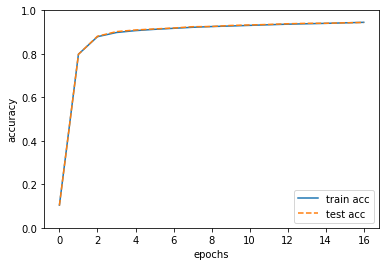

In [6]:
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []
# 平均每个epoch的重复次数
iter_per_epoch = max(train_size / batch_size, 1)

# 超参数
iters_num = 10000  # 适当设定循环的次数
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 获取mini-batch
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 计算梯度
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch) # 高速版！
    
    # 更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    # 计算每个epoch的识别精度
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

上面的例子中，每经过一个 epoch，就对所有的训练数据和测试数据计算识别精度，并记录结果。之所以要计算每一个 epoch 的识别精度，是因为如果在for语句的循环中一直计算识别精度，会花费太多时间。并且也没有必要那么频繁地记录识别精度（只要从大体方向上大致把握识别精度的推移就可以了）。因此，我们才会每经过一个 epoch 就记录一次训练数据的识别精度。

上图中，实现表示训练数据的识别精度，虚线表示测试数据的识别精度。如图所示，随着学习的进行，我们发现使用训练数据和测试数据评价的识别精度都提高了，并且，这两个识别精度基本上没有差异（两条线重叠在一起）。因此，可以说这次的学习中没有发生过拟合的现象。

### 小节

我们学习了神经网络的学习。首先，为了能顺利进行神经网络的学习，我们导入了损失函数这个指标。以这个损失函数为基准，找出使它的值达到最小的权重参数，就是神经网络的学习目标。为了找到尽可能小的损失函数值，我们介绍了使用函数斜率的梯度法。

* 机器学习中使用的数据集分为训练数据和测试数据。
* 神经网络用训练数据进行学习，并用测试数据评价学习到的模型的泛化能力。
* 神经网络的学习以损失函数为指标，更新权重参数，以使损失函数的值减小。
* 利用某个给定的微小值的差分求倒数的过程，就是数值微分。
* 利用数值微分，可以计算权重参数的梯度。
* 数值微分虽然费时间，但是实现起来很简单。下一章中要实现的稍微复杂一些的误差反向传播法可以高速地计算梯度。